In [252]:
#%matplotlib notebook
%matplotlib inline

In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import glob
import os.path
import scipy.io
import skimage.io

Script used to make this data is in `/bf_pulse/workflows/lsm700_sigbyfp.sh`

# First Lets look at the raw histograms. 

In [146]:
bgsub_dir = "../../proc_data/slice63x_bg_subtract/November_2014/63x_optimization/"
sbsub_dir = "../../proc_data/slice63x_sigb_yfp/images/"
WTonly = [ f for f in glob.glob(bgsub_dir + "**/WT*.lsm", recursive=True) if "/10x/" not in f]
RFPonly = [ f for f in glob.glob(bgsub_dir + "**/RFP*.lsm", recursive=True) if "/10x/" not in f]
YFPRFP = [ f for f in glob.glob(sbsub_dir + "**/SigB_72*center*stitched.tiff", recursive=True) if "/segmented/" not in f]

In [147]:
def get_file_dirname(path):
    filename = os.path.splitext(os.path.basename(path))[0]
    dirname = os.path.dirname(path)
    return dirname, filename

In [170]:
def get_pixels(imagepath, maskname, color):
    dirname, basename = get_file_dirname(imagepath)
    basepath = os.path.join(dirname, basename, basename)
    datapath = basepath + "_" + maskname + ".mat"
    imgpath = basepath + "_c{0}.tiff".format(color[0])
    if maskname == "distmap":
        dm = scipy.io.loadmat(datapath)["distmap_masked"]
        data = (dm<20) & (dm>0) # just tops
    else:
        data = scipy.io.loadmat(datapath)["image"]
    img = skimage.io.imread(imgpath)
    return np.ravel(img[data==1])


In [165]:
def get_all_pixels(list_of_files, mask):
    return np.hstack([get_pixels(f, mask, "green") for f in list_of_files])

In [166]:
bg = get_all_pixels(WTonly+RFPonly, "background")
af = get_all_pixels(RFPonly, "segmented")
sb = get_all_pixels(YFPRFP, "distmap")

### Load up the computed mean levels. 

In [250]:
with open(outdir + "bg_values.json") as fp:
    redux_means_63x = json.load(fp)

In [244]:
redux_means_63x

{'green_actual_all': 1187.5029000734905,
 'green_actual_bottom': 791.4385190859332,
 'green_actual_top': 2765.053286462306,
 'green_autofluor': 502.815478616573,
 'green_bg': 120.40242737839569,
 'green_bleedthrough': 705.9279593584986,
 'green_raw_actual_all': 2176.470908222415,
 'green_raw_actual_bottom': 1728.1424628704567,
 'green_raw_actual_top': 3911.728711859721,
 'red_autofluor': 109.26107183163919,
 'red_bg': 94.36543117453655}

Show the histograms used to compute these values and overlay the means. 

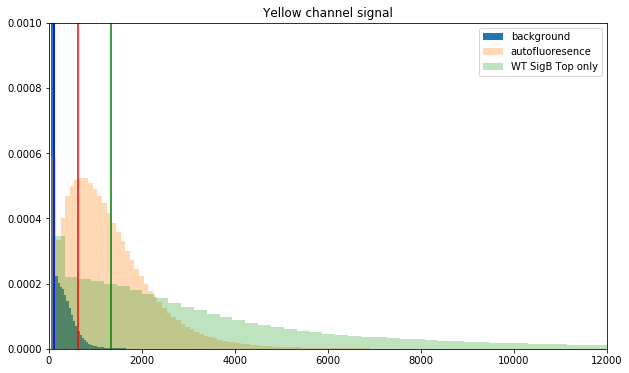

In [259]:
plt.figure(figsize=(10,6))
ymax = 0.001
plt.hist(bg, bins=200, density=True, alpha=1.0, label="background");
plt.vlines(redux_means_63x["green_bg"], 0, ymax, color="blue")
plt.hist(af, bins=200, density=True, alpha=0.3, label="autofluoresence");
plt.vlines(redux_means_63x["green_bg"] + redux_means_63x["green_autofluor"], 0, ymax, color="red")
plt.hist(sb, bins=200, density=True, alpha=0.3, label="WT SigB Top only")
plt.vlines(redux_means_63x["green_bg"] + redux_means_63x["green_autofluor"] + redux_means_63x["green_bleedthrough"], 0, ymax, color="green")
plt.legend()
plt.ylim(0, ymax)
plt.xlim(0, 12000)
plt.title("Yellow channel signal")
plt.show() # make figure visible in gitlab

So there is quite an overlap with the Top YFP signal and autofluoresence

## The numbers for the individual images. 

In [251]:
bleed_redux = pd.read_csv(outdir + "bg_values.tsv", sep="\t", index_col="index")

In [238]:
bleed_redux.drop(['dir_name'], axis=1)

,file_name,strain,red_bg,red_autofluor,green_bg,green_autofluor,green_bleedthrough,green_actual_all,green_actual_bottom,green_actual_top,green_raw_actual_all,green_raw_actual_bottom,green_raw_actual_top
index,,,,,,,,,,,,,
0,RFP_only_72hrs_center_2_base,RFP,132.296696,NaN,202.168610,NaN,391.885659,NaN,NaN,NaN,NaN,NaN,NaN
1,RFP_only_72hrs_center_2_middle,RFP,NaN,NaN,NaN,NaN,716.403097,NaN,NaN,NaN,NaN,NaN,NaN
2,RFP_only_72hrs_center_2_middle2,RFP,NaN,NaN,NaN,NaN,500.669056,NaN,NaN,NaN,NaN,NaN,NaN
3,RFP_only_72hrs_center_2_top,RFP,113.316923,NaN,112.735289,NaN,971.424656,NaN,NaN,NaN,NaN,NaN,NaN
4,RFP_only_72hrs_center_3_base,RFP,91.692211,NaN,116.786337,NaN,405.916677,NaN,NaN,NaN,NaN,NaN,NaN
5,RFP_only_72hrs_center_3_middle,RFP,NaN,NaN,NaN,NaN,714.860447,NaN,NaN,NaN,NaN,NaN,NaN
6,RFP_only_72hrs_center_3_middle2,RFP,NaN,NaN,NaN,NaN,554.488684,NaN,NaN,NaN,NaN,NaN,NaN
7,RFP_only_72hrs_center_3_top,RFP,107.159272,NaN,109.924949,NaN,985.747434,NaN,NaN,NaN,NaN,NaN,NaN
8,RFP_only_72hrs_center_base,RFP,NaN,NaN,NaN,NaN,680.046114,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def area_plots(ax, df, mean_vals, columns, labels, colors):
    ax = df[columns].plot.area(ax=ax, linewidth=0, color=colors)
    leg = ax.get_legend() 
    for l, t in zip(leg.get_texts(), labels):
        l.set_text(t)
    #leg.set_loc("upper left")
    total = 0
    artists = []
    for col in columns:
        total += mean_vals[col]
        ax.axhline(total, linewidth=1.0, color="black")
        #ax.annotate()
    ax.set_xlabel("")
    return ax, artists

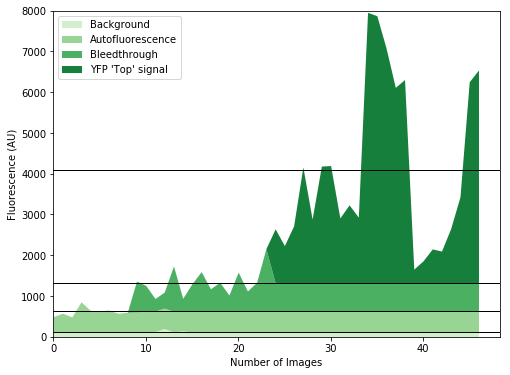

In [260]:
indiv_df = bleed_redux.copy()
means_df = redux_means_63x.copy()

indiv_df["strain"] = pd.Categorical(indiv_df["strain"], categories=["WT", "RFP", "SigB"], ordered=True)
indiv_df.sort_values(by=["strain"], inplace=True)
indiv_df = indiv_df.reset_index(drop=True)

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8, 6)


columns_green = ['green_bg',
                'green_autofluor',
                'green_bleedthrough',"green_actual_top" ] 
new_labels = ["Background", "Autofluorescence", "Bleedthrough", "YFP 'Top' signal"]

n = len(columns_green)+1
greens = [plt.cm.Greens(i/n) for i in range(1, n)]

indiv_df.loc[indiv_df["green_bg"].isnull(), "green_bg"] = means_df["green_bg"]
indiv_df.loc[indiv_df["strain"]=="RFP", "green_autofluor"] = means_df["green_autofluor"]
indiv_df.loc[indiv_df["strain"]=="SigB", "green_autofluor"] = means_df["green_autofluor"]
indiv_df.loc[indiv_df["strain"]=="SigB", "green_bleedthrough"] = means_df["green_bleedthrough"]

ax,_ = area_plots(ax, indiv_df, means_df, columns_green, new_labels, greens)

a = ax
a.get_yaxis().set_tick_params(direction='out')
a.get_xaxis().set_tick_params(direction='out')
a.set_xlim(left=0)
a.set_ylim(0, 8000)
a.set_xlabel("Number of Images")
a.set_ylabel("Fluorescence (AU)")
plt.show() # make figure visible in gitlab

## Bleed through from the RFP channel counts for

### Ratio of bleed through to the YFP signal 

In [231]:
redux_means_63x["green_bleedthrough"]/redux_means_63x["green_actual_top"]

0.4794728299290087

### Proportion of Green Signal that is RFP (estimated from means)

In [247]:
green_signal =  sum([ redux_means_63x[k] for k in ["green_bg", "green_autofluor", "green_bleedthrough", "green_actual_top"]])

In [248]:
redux_means_63x["green_bleedthrough"]/green_signal

0.17242150007417695

In [249]:
redux_means_63x["green_bleedthrough"]/redux_means_63x["green_raw_actual_top"]

0.18046444714282986